In [1]:
from typing import Union, List
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyblock
from scipy.optimize import minimize

In [2]:
def walk(atoms: int,
         timesteps: np.ndarray,
         jump_size: int = 1,
         seed: np.random.mtrand.RandomState = np.random.RandomState()) -> np.ndarray:
    """
    Perform a random walk.

    :param atoms: number of atoms
    :param timesteps: the timestep values
    :param jump_size: size of jump
    :param seed: random seed source
    :return: cumulative sum of steps for walk
    """
    possible_moves = np.zeros((6, 3))
    j = 0
    for i in range(0, 6, 2):
        possible_moves[i, j] = jump_size
        possible_moves[i + 1, j] = -jump_size
        j += 1
    choices = seed.choice(len(range(len(possible_moves))), size=(atoms, len(timesteps)))
    steps = np.zeros((atoms, len(timesteps), 3))
    for i in range(steps.shape[0]):
        for j in range(steps.shape[1]):
            steps[i, j] = possible_moves[choices[i, j]]
    cum_steps = np.cumsum(steps, axis=1)
    return cum_steps

In [ ]:
# Copyright (c) Andrew R. McCluskey
# Distributed under the terms of the MIT License
# author: Andrew R. McCluskey (arm61)

import numpy as np
from tqdm import tqdm
#from random_walk import walk

jump = 1
atoms = 124
length = 128
size = 5000

std_est = np.zeros((length,size))
pyblock_est = np.zeros((length,size))

timestep = np.arange(1, length + 1, 1, dtype=int)
k = np.zeros((size, timestep.size))
dx_mean = np.zeros((length,size))



for seed in tqdm(range(size)):

    dx_store = []
    rng = np.random.RandomState(seed)
    cum_steps = walk(atoms, timestep, seed=rng, jump_size=jump)

    for i, n in enumerate(timestep):
        disp = np.concatenate([cum_steps[:, np.newaxis, i],
                               np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                              axis=1)
        
        #d_x = np.tensordot(np.array((0.4,0.8,0.6)),disp, axes=[[0],[2]]) #np.abs(disp[:,:,0])
        d_x = np.dot(disp, np.array((1,1,1)))


        k[seed, i] = np.mean(d_x.flatten())
        std_est[i,seed] = np.var(d_x)/(timestep[-1]/timestep[i]*124)

        reblock = pyblock.blocking.reblock(d_x.flatten())
        opt_block = pyblock.blocking.find_optimal_block(d_x.flatten().size, reblock)
        pyblock_est[i,seed] =  reblock[opt_block[0]].std_err**2

        dx_store.append(d_x)
        
        
    for x in range(length):
        dx_mean[x,seed] = np.mean(dx_store[x],axis = (0,1)) # Takes the mean across time intervals and atoms


std_num = k.var(0)


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [05:16<00:00, 15.80it/s]


In [4]:
dx_mean.shape

(128, 5000)

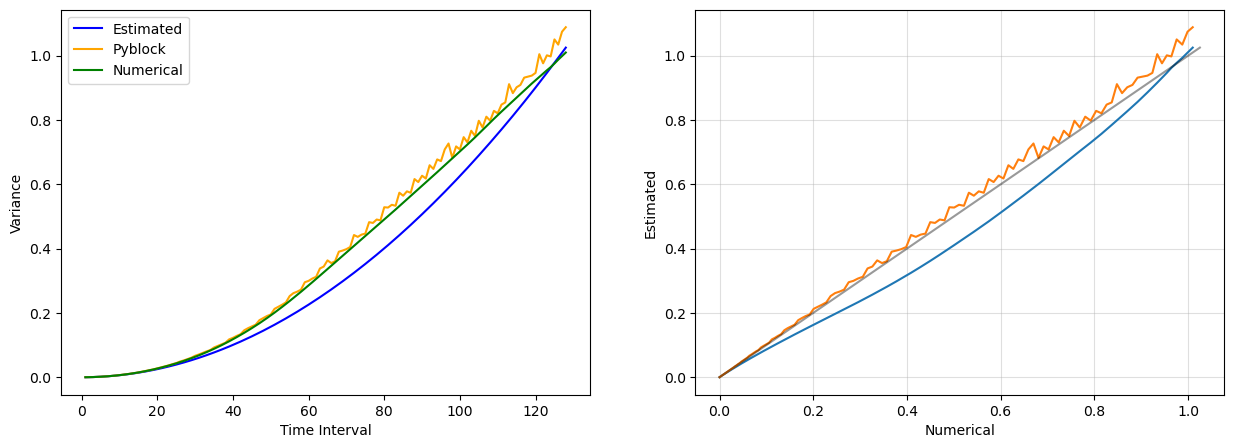

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(timestep,np.mean(std_est,axis = 1), color = 'blue')
ax[0].plot(timestep,np.mean(pyblock_est,axis=1), color = 'orange')
ax[0].plot(timestep,std_num, color = 'green')
ax[0].legend(['Estimated','Pyblock', 'Numerical'])
ax[0].set_xlabel('Time Interval')
ax[0].set_ylabel('Variance')

# ax[1].plot(timestep,std_num/np.mean(std_est,axis = 1))
# ax[1].grid(alpha = 0.4)

ax[1].plot(std_num,np.mean(std_est,axis = 1))
ax[1].plot(std_num,np.mean(pyblock_est,axis = 1))
ax[1].set_xlabel('Numerical')
ax[1].set_ylabel('Estimated')
ax[1].plot(np.linspace(0,np.mean(std_est,axis = 1).max(),100),np.linspace(0,np.mean(std_est,axis = 1).max(),100), c = 'k', alpha = 0.4)
ax[1].grid(alpha = 0.4)

<ErrorbarContainer object of 3 artists>

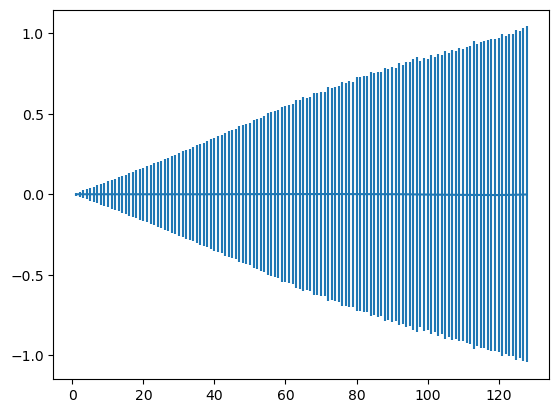

In [6]:
plt.errorbar(timestep,dx_mean.mean(axis = 1), yerr = np.sqrt(np.mean(pyblock_est,axis = 1)))

In [7]:
from scipy.stats import truncnorm

# Stanard error propogation

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


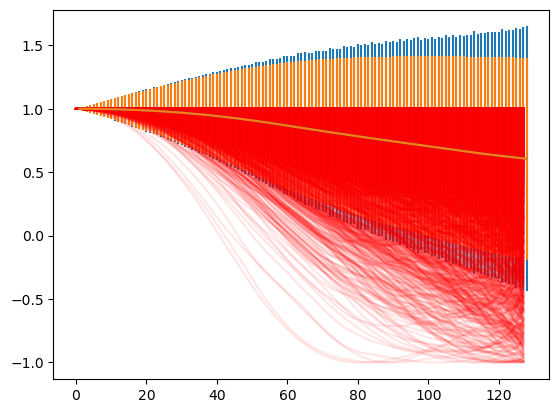

In [8]:
err = np.sqrt(pyblock_est.mean(axis = 1))
num_mean = np.mean(np.exp(1j*dx_mean),axis = 1)
num_std = np.std(np.exp(1j*dx_mean),axis = 1)

circ_error = np.sqrt(1 - np.exp(-err**2/2))


#plt.errorbar(timestep,np.real(dx_test),err)

plt.errorbar(timestep,num_mean,err)
plt.errorbar(timestep,num_mean,num_std)
#plt.errorbar(timestep,circ_mean,circ_error)
plt.plot(np.exp(1j*dx_mean), alpha = 0.1, color = 'red')
plt.show()

In [9]:
d_exp = np.exp(1j*dx_mean)

In [10]:
from scipy.stats import lognorm

In [11]:
def trunc_sampler(means,err):

    # means = np.exp(1j*dx_mean)[:,15].real

    # Constrain bounds
    lower= -np.inf
    upper = 1

    # Sample from truncated normal at each point
    samples = []
    for mu, sigma in zip(means, err):
        a = (lower - mu) / sigma
        b = (upper - mu) / sigma
        truncated_samples = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=10000) 
        samples.append(truncated_samples)

    
    samples = np.array(samples)

    return samples.mean(axis=1), samples.std(axis=1)


In [12]:
def log_sampler(means,err):


    samples = []
    for mu, sigma in zip(means, err):
        log_samp = lognorm.rvs(mu,sigma,size=10000) 
        samples.append(log_samp)

    
    samples = np.array(samples)

    return samples.mean(axis=1), samples.std(axis=1)

In [13]:
log_mean, log_std = log_sampler(np.real(num_mean),err)

In [14]:
sampled_means = np.zeros((128,size))
sampled_std = np.zeros((128,size))


for x in tqdm(range(size)):
    sampled_means[:,x], sampled_std[:,x] = trunc_sampler(np.real(d_exp[:,x]),pyblock_est[:,x])


100%|██████████| 5000/5000 [05:59<00:00, 13.93it/s]


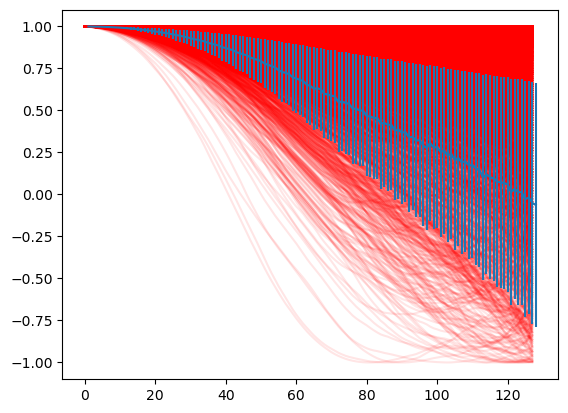

In [15]:

#plt.errorbar(timestep,np.real(dx_test),err)
plt.plot(np.exp(1j*dx_mean), alpha = 0.1, color = 'red')
#plt.errorbar(timestep,log_mean,log_std)
plt.errorbar(timestep,sampled_means.mean(axis=1),sampled_std.mean(axis=1))
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6865: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


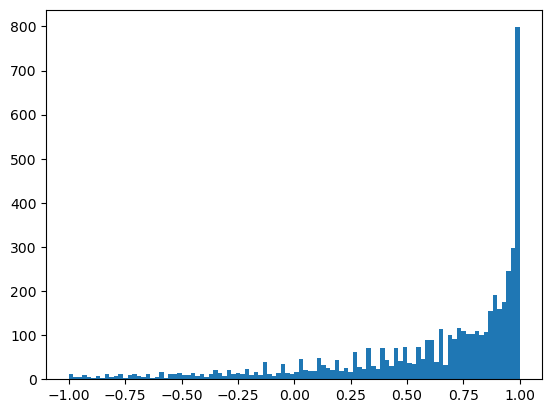

In [16]:
plt.hist(np.exp(1j*dx_mean)[-1,:], bins = 100)
plt.show()

Text(0, 0.5, 'Estimated')

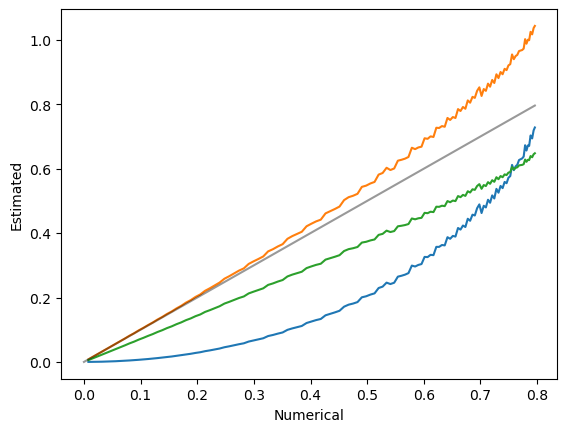

In [17]:
circ_error = np.sqrt(1 - np.exp(-err**2/2))
std_num = np.std(np.exp(1j*dx_mean),axis = 1)
plt.plot(std_num,sampled_std.mean(axis=1))
plt.plot(std_num,err)
plt.plot(std_num,circ_error)
plt.plot(np.linspace(0,std_num.max(),100),np.linspace(0,std_num.max(),100), c = 'k', alpha = 0.4)
plt.xlabel('Numerical')
plt.ylabel('Estimated')

In [ ]:
# estimated variance

n_atoms = 124
dt = np.arange(1, 129, 1)
n_runs = 100
box_size = [10,10,10]

q_points = np.array([1,1,1])
#q_points = q_points[:, np.newaxis]

int_scat = np.zeros((n_runs,len(dt),len(q_points)))


int_scat_1 = np.zeros((n_runs,len(dt)))

for j in tqdm(range(n_runs)):
    steps = walk(n_atoms, dt, seed=np.random.RandomState(j))
    cum_steps = np.cumsum(steps, axis=1)
    disp_3d = []
    n_i = np.array([])
    for k in range(0,len(q_points)):
        for i, n in enumerate(dt):
            disp = np.concatenate([cum_steps[:, np.newaxis, i],
                                    np.subtract(cum_steps[:, i + 1:], cum_steps[:, :-(i + 1)])],
                                    axis=1) % box_size
            

            int_scat_1[j,i] = np.mean(np.mean(np.exp(1j * np.dot(disp, q_points)), axis = 1))



  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_90870/938125735.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  int_scat_1[j,i] = np.mean(np.mean(np.exp(1j * np.dot(disp, q_points)), axis = 1))


(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(

  1%|          | 1/100 [00:00<00:26,  3.75it/s]

(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 12

  2%|▏         | 2/100 [00:00<00:25,  3.78it/s]

(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(1

  3%|▎         | 3/100 [00:00<00:27,  3.55it/s]

(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)


  4%|▍         | 4/100 [00:01<00:26,  3.63it/s]

(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 2

  5%|▌         | 5/100 [00:01<00:25,  3.68it/s]

(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(1

  6%|▌         | 6/100 [00:01<00:25,  3.72it/s]

(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)


  7%|▋         | 7/100 [00:01<00:24,  3.74it/s]

(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(12

  8%|▊         | 8/100 [00:02<00:24,  3.74it/s]

(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124

  9%|▉         | 9/100 [00:02<00:24,  3.75it/s]

(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)


 10%|█         | 10/100 [00:02<00:24,  3.73it/s]

(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)


 11%|█         | 11/100 [00:02<00:23,  3.73it/s]

(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124,

 12%|█▏        | 12/100 [00:03<00:23,  3.76it/s]

(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)


 13%|█▎        | 13/100 [00:03<00:23,  3.64it/s]

(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)

 14%|█▍        | 14/100 [00:03<00:23,  3.71it/s]

(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(12

 15%|█▌        | 15/100 [00:04<00:22,  3.70it/s]

(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)


 16%|█▌        | 16/100 [00:04<00:22,  3.70it/s]

(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)

 17%|█▋        | 17/100 [00:04<00:22,  3.74it/s]

(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 11

 18%|█▊        | 18/100 [00:04<00:22,  3.73it/s]

(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)


 19%|█▉        | 19/100 [00:05<00:21,  3.71it/s]

(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)


 20%|██        | 20/100 [00:05<00:21,  3.70it/s]

(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(1

 21%|██        | 21/100 [00:05<00:21,  3.72it/s]

(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)


 22%|██▏       | 22/100 [00:05<00:21,  3.63it/s]

(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124

 23%|██▎       | 23/100 [00:06<00:20,  3.68it/s]

(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)


 24%|██▍       | 24/100 [00:06<00:20,  3.69it/s]

(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)


 25%|██▌       | 25/100 [00:06<00:20,  3.71it/s]

(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(

 26%|██▌       | 26/100 [00:07<00:19,  3.73it/s]

(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 

 27%|██▋       | 27/100 [00:07<00:19,  3.75it/s]

(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124,

 28%|██▊       | 28/100 [00:07<00:19,  3.77it/s]

(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 1

 29%|██▉       | 29/100 [00:07<00:18,  3.77it/s]

(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(1

 30%|███       | 30/100 [00:08<00:19,  3.65it/s]

(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)


 31%|███       | 31/100 [00:08<00:18,  3.65it/s]

(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24

 32%|███▏      | 32/100 [00:08<00:18,  3.67it/s]

(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(1

 33%|███▎      | 33/100 [00:08<00:18,  3.68it/s]

(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)


 34%|███▍      | 34/100 [00:09<00:17,  3.69it/s]

(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)

 35%|███▌      | 35/100 [00:09<00:17,  3.69it/s]

(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124,

 36%|███▌      | 36/100 [00:09<00:17,  3.67it/s]

(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)


 37%|███▋      | 37/100 [00:10<00:17,  3.60it/s]

(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)


 38%|███▊      | 38/100 [00:10<00:17,  3.58it/s]

(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)


 39%|███▉      | 39/100 [00:10<00:16,  3.60it/s]

(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6

 40%|████      | 40/100 [00:10<00:16,  3.64it/s]

(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(

 41%|████      | 41/100 [00:11<00:16,  3.65it/s]

(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)


 42%|████▏     | 42/100 [00:11<00:15,  3.66it/s]

(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)


 43%|████▎     | 43/100 [00:11<00:15,  3.68it/s]

(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 

 44%|████▍     | 44/100 [00:11<00:15,  3.70it/s]

(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)


 45%|████▌     | 45/100 [00:12<00:14,  3.74it/s]

(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(1

 46%|████▌     | 46/100 [00:12<00:14,  3.66it/s]

(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(12

 47%|████▋     | 47/100 [00:12<00:14,  3.68it/s]

(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)


 48%|████▊     | 48/100 [00:12<00:13,  3.73it/s]

(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124,

 49%|████▉     | 49/100 [00:13<00:13,  3.75it/s]

(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)


 50%|█████     | 50/100 [00:13<00:13,  3.75it/s]

(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)


 51%|█████     | 51/100 [00:13<00:13,  3.73it/s]

(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(12

 52%|█████▏    | 52/100 [00:14<00:12,  3.75it/s]

(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)


 53%|█████▎    | 53/100 [00:14<00:12,  3.64it/s]

(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(12

 54%|█████▍    | 54/100 [00:14<00:12,  3.69it/s]

(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 12

 55%|█████▌    | 55/100 [00:14<00:12,  3.73it/s]

(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(12

 56%|█████▌    | 56/100 [00:15<00:11,  3.75it/s]

(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)


 57%|█████▋    | 57/100 [00:15<00:11,  3.76it/s]

(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(12

 58%|█████▊    | 58/100 [00:15<00:11,  3.76it/s]

(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)


 59%|█████▉    | 59/100 [00:15<00:11,  3.63it/s]

(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124,

 60%|██████    | 60/100 [00:16<00:10,  3.69it/s]

(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 

 61%|██████    | 61/100 [00:16<00:10,  3.71it/s]

(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124

 62%|██████▏   | 62/100 [00:16<00:10,  3.71it/s]

(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)


 63%|██████▎   | 63/100 [00:17<00:09,  3.72it/s]

(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(

 64%|██████▍   | 64/100 [00:17<00:09,  3.73it/s]

(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)


 65%|██████▌   | 65/100 [00:17<00:09,  3.60it/s]

(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)


 66%|██████▌   | 66/100 [00:17<00:09,  3.64it/s]

(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(1

 67%|██████▋   | 67/100 [00:18<00:09,  3.66it/s]

(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(1

 68%|██████▊   | 68/100 [00:18<00:08,  3.70it/s]

(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)


 69%|██████▉   | 69/100 [00:18<00:08,  3.73it/s]

(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)


 70%|███████   | 70/100 [00:18<00:08,  3.73it/s]

(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 

 71%|███████   | 71/100 [00:19<00:08,  3.62it/s]

(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)


 72%|███████▏  | 72/100 [00:19<00:07,  3.63it/s]

(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)


 73%|███████▎  | 73/100 [00:19<00:07,  3.65it/s]

(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24

 74%|███████▍  | 74/100 [00:20<00:07,  3.69it/s]

(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)


 75%|███████▌  | 75/100 [00:20<00:06,  3.72it/s]

(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(

 76%|███████▌  | 76/100 [00:20<00:06,  3.62it/s]

(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)


 77%|███████▋  | 77/100 [00:20<00:06,  3.65it/s]

(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 1

 78%|███████▊  | 78/100 [00:21<00:05,  3.69it/s]

(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)


 79%|███████▉  | 79/100 [00:21<00:05,  3.73it/s]

(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124,

 80%|████████  | 80/100 [00:21<00:05,  3.75it/s]

(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)


 81%|████████  | 81/100 [00:21<00:05,  3.66it/s]

(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(1

 82%|████████▏ | 82/100 [00:22<00:04,  3.71it/s]

(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)

 83%|████████▎ | 83/100 [00:22<00:04,  3.74it/s]

(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(1

 84%|████████▍ | 84/100 [00:22<00:04,  3.77it/s]

(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)


 85%|████████▌ | 85/100 [00:22<00:03,  3.78it/s]

(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)

 86%|████████▌ | 86/100 [00:23<00:03,  3.67it/s]

(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(

 87%|████████▋ | 87/100 [00:23<00:03,  3.72it/s]

(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)


 88%|████████▊ | 88/100 [00:23<00:03,  3.70it/s]

(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124

 89%|████████▉ | 89/100 [00:24<00:02,  3.73it/s]

(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)


 90%|█████████ | 90/100 [00:24<00:02,  3.74it/s]

(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)


 91%|█████████ | 91/100 [00:24<00:02,  3.62it/s]

(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(12

 92%|█████████▏| 92/100 [00:24<00:02,  3.64it/s]

(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 

 93%|█████████▎| 93/100 [00:25<00:01,  3.69it/s]

(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)


 94%|█████████▍| 94/100 [00:25<00:01,  3.70it/s]

(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)


 95%|█████████▌| 95/100 [00:25<00:01,  3.72it/s]

(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 

 96%|█████████▌| 96/100 [00:25<00:01,  3.62it/s]

(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124

 97%|█████████▋| 97/100 [00:26<00:00,  3.67it/s]

(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)


 98%|█████████▊| 98/100 [00:26<00:00,  3.66it/s]

(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)
(124, 87)
(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 12

 99%|█████████▉| 99/100 [00:26<00:00,  3.69it/s]

(124, 86)
(124, 85)
(124, 84)
(124, 83)
(124, 82)
(124, 81)
(124, 80)
(124, 79)
(124, 78)
(124, 77)
(124, 76)
(124, 75)
(124, 74)
(124, 73)
(124, 72)
(124, 71)
(124, 70)
(124, 69)
(124, 68)
(124, 67)
(124, 66)
(124, 65)
(124, 64)
(124, 63)
(124, 62)
(124, 61)
(124, 60)
(124, 59)
(124, 58)
(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 

100%|██████████| 100/100 [00:27<00:00,  3.70it/s]

(124, 57)
(124, 56)
(124, 55)
(124, 54)
(124, 53)
(124, 52)
(124, 51)
(124, 50)
(124, 49)
(124, 48)
(124, 47)
(124, 46)
(124, 45)
(124, 44)
(124, 43)
(124, 42)
(124, 41)
(124, 40)
(124, 39)
(124, 38)
(124, 37)
(124, 36)
(124, 35)
(124, 34)
(124, 33)
(124, 32)
(124, 31)
(124, 30)
(124, 29)
(124, 28)
(124, 27)
(124, 26)
(124, 25)
(124, 24)
(124, 23)
(124, 22)
(124, 21)
(124, 20)
(124, 19)
(124, 18)
(124, 17)
(124, 16)
(124, 15)
(124, 14)
(124, 13)
(124, 12)
(124, 11)
(124, 10)
(124, 9)
(124, 8)
(124, 7)
(124, 6)
(124, 5)
(124, 4)
(124, 3)
(124, 2)
(124, 1)
(124, 128)
(124, 127)
(124, 126)
(124, 125)
(124, 124)
(124, 123)
(124, 122)
(124, 121)
(124, 120)
(124, 119)
(124, 118)
(124, 117)
(124, 116)
(124, 115)
(124, 114)
(124, 113)
(124, 112)
(124, 111)
(124, 110)
(124, 109)
(124, 108)
(124, 107)
(124, 106)
(124, 105)
(124, 104)
(124, 103)
(124, 102)
(124, 101)
(124, 100)
(124, 99)
(124, 98)
(124, 97)
(124, 96)
(124, 95)
(124, 94)
(124, 93)
(124, 92)
(124, 91)
(124, 90)
(124, 89)
(124, 88)


In [46]:
int_scat_1[:,10].shape

(100,)

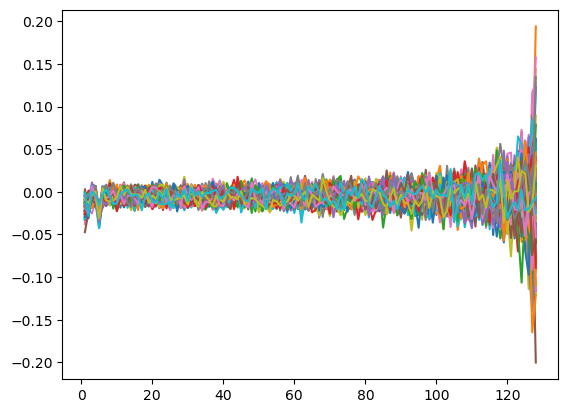

In [48]:
plt.plot(dt,int_scat_1.T)
plt.show()